<a href="https://colab.research.google.com/github/marvher/Data_Driven_Decisions_MTC-Seminar_SS2019.FAU/blob/main/DeepVis_IMAGE_CLASSIFICATION_SWEEPS_noEarly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

## Weights & Biases

In [1]:
%%capture 
!pip install wandb --upgrade

In [2]:
import wandb

wandb.login()

wandb: Currently logged in as: marvher (use `wandb login --relogin` to force relogin)


True

In [3]:
sweep_config = {
    'method': 'random', #grid, random
    'metric': {
      'name': 'loss',
      'goal': 'minimize'   
    },
    'parameters': {
        'epochs': {
            'values': [50, 100, 200]
        },
        'batch_size': {
            'values': [256, 128, 64, 32]
        },
        'dropout': {
            'values': [0.3, 0.5, 0.7]
        },
        'kernel_size': {
            'values': [3, 5, 7]
        },
        'learning_rate': {
            'values': [1e-2, 1e-3, 1e-4, 3e-4, 3e-5, 1e-5]
        },
        'fc_layer_size':{
            'values':[128, 256, 512]
        },
        'optimizer': {
            'values': ['adam', 'sgd', 'adadelta']
        },
    }
}

In [4]:
# Default values for hyper-parameters we're going to sweep over
config_defaults = {
    'epochs': 5,
    'batch_size': 128,
    'learning_rate': 1e-3,
    'optimizer': 'adam',
    'fc_layer_size': 128,
    'dropout': 0.5,
    'kernel_size': 3
}

# # Initialize a new wandb run
wandb.init(project='waferimages-sweeps', entity='inceptioneers', config=config_defaults)

# # Config is a variable that holds and saves hyperparameters and inputs
config = wandb.config

In [5]:
sweep_id = wandb.sweep(sweep_config, project='waferimages-sweeps', entity='inceptioneers')

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


Create sweep with ID: nygp64a8
Sweep URL: https://wandb.ai/inceptioneers/waferimages-sweeps/sweeps/nygp64a8


In [6]:
# 1. Start a new run
#wandb.init(project='waferimages', entity='inceptioneers', config=config)

# 2. Save model inputs and hyperparameters
#config = wandb.config

## Libraries & Seed

In [7]:
import pandas as pd
import numpy as np
import glob
import random
import joblib
import os

from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import matplotlib.patches as patches
#import cv2

from skimage import io

from imutils import paths
from sklearn import preprocessing
from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit

import torch
from torchvision import transforms, datasets
from torchvision.datasets import ImageFolder

import ipywidgets as widgets
from IPython.display import display
import copy

The next block of code applies a seed to our code for reproducibility and also sets the computation device. 

In [8]:
def seed_libraries(SEED=42):
  # Python seeds
  random.seed(SEED)
  np.random.seed(SEED)
  # Torch seeds
  torch.manual_seed(SEED)
  torch.cuda.manual_seed(SEED)
  torch.cuda.manual_seed_all(SEED)

SEED=42
seed_libraries(SEED=SEED)


# set computation device
runtime = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f"Computation device: {runtime}")

Computation device: cuda


# **Set Dicitonaries**

**Google Drive Version**

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [10]:
# !unzip /content/drive/MyDrive/data.zip

In [11]:
DIR_DATEN = "/content/drive/MyDrive/DEEPVIS/data"   # make sure to always adapt this to your own folser structure
DIR_DATEN_01 = os.path.join(DIR_DATEN, "01_Daten")
DIR_WAFER_IMAGES = os.path.join(DIR_DATEN, "WaferImages")

## **Load Data**

In [12]:
labels_filename ="Labels_Waferviertel.xlsx"
meta_filename = "Meta_data.csv"

In [13]:
labels = pd.read_excel(os.path.join(DIR_DATEN_01, labels_filename))
labels.head(5)

,File Name,Part No,Crack,Patch,Scratch,Low Level,Circle,Displaced,Splinter,Stain,Wafer on Pin,Other,PosX,PosY,Timestamp,PreviousClass,NoOfErrors
0,001932631.tif,0,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:45,other,1
1,001932631.tif,1,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:45,other,1
2,001932631.tif,2,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:45,other,1
3,001932631.tif,3,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:45,other,1
4,001945868.tif,0,False,False,False,False,False,False,False,False,False,True,0,0,2019-06-12 13:48:47,other,1


In [14]:
labels["PreviousClass"].unique()  # we don't need that any longer?

array(['other', 'patch', 'circle', 'splinter', 'stain', 'waferonpin',
       'crack', 'scratch'], dtype=object)

## **Meta-Data**

In [15]:
meta = pd.read_csv(os.path.join(DIR_DATEN_01, meta_filename))
meta

,file_name,wafer_id,gray_mean,class,NameBild,SUBSTRATEIDENT,TIMESTAMP_CTS,CTS_EFF,CTS_FF,CTS_VOC,CTS_ISC,CTS_RSER,CTS_RSH,CTS_IREV2_T,CTS_B2B_1,CTS_JOB_NR,CTS_EL_CRACK_COUNT,CTS_EL_DARKAREA_COUNT
0,002152418.tif,2152418,183.47,Cracks,002152418.tif,11790109.0,2018-07-26 14:46:26,23.136937,0.814332,737.587,9.412589,4.987,4481.251483,0.331505,20.010000,20180726 Exp 66,0.0,0.0
1,001889692.tif,1889692,176.80,Cracks,001889692.tif,11232718.0,2018-02-27 13:19:22,23.041940,0.810728,735.176,9.445444,5.032,3471.378009,0.040560,35.639999,20180227 HD556,1.0,0.0
2,001897005.tif,1897005,177.04,Cracks,001897005.tif,11278998.0,2018-03-05 15:07:20,23.073799,0.811632,735.720,9.441592,4.906,3821.416372,0.021333,38.169998,20180305 HD547-4,0.0,0.0
3,001962325.tif,1962325,172.97,Cracks,001962325.tif,11403759.0,2018-04-04 11:41:30,22.571537,0.797088,734.655,9.417174,5.329,3016.940429,0.006562,38.720001,20180328 M2R,1.0,0.0
4,002152288.tif,2152288,173.58,Cracks,002152288.tif,11794609.0,2018-07-26 14:34:30,23.001560,0.810923,735.170,9.428756,5.170,1169.261436,0.182121,20.059999,20180726 Exp 66,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6101,002126113.tif,2126113,213.27,gute_Wafer,002126113.tif,11734418.0,2018-07-02 11:44:45,23.665103,0.821231,744.152,9.462665,4.680,4500.504749,0.009221,43.840000,20180702 EXP41,0.0,0.0
6102,002160320.tif,2160320,172.81,gute_Wafer,002160320.tif,11825342.0,2018-08-02 10:34:09,22.769944,0.800344,734.057,9.471267,5.318,25349.092305,0.000851,19.879999,20180802 EXP 99,0.0,0.0
6103,002161033.tif,2161033,201.44,gute_Wafer,002161033.tif,11827179.0,2018-08-02 11:35:48,23.229798,0.811132,740.253,9.453416,4.889,14218.466321,0.001039,22.299999,20180802 EXP 99,0.0,0.0
6104,002161876.tif,2161876,194.77,gute_Wafer,002161876.tif,11807331.0,2018-08-03 12:47:42,23.060322,0.810989,736.246,9.435790,5.220,2525.808870,0.008307,26.870001,20180803 EXP 58,0.0,0.0


In [16]:
meta["class"].unique()

array(['Cracks', 'Flecken', 'Kratzer', 'low_level', 'Punkte',
       'schlecht_positioniert', 'Sonstiges', 'Splitter_im_Tester',
       'Verschmutzung', 'Wafer_auf_Pin', 'gute_Wafer'], dtype=object)

## **Load, Select and Encode Images**

In [17]:
# get all the image paths
image_paths = list(paths.list_images(DIR_WAFER_IMAGES))

# create an empty DataFrame
data = pd.DataFrame()

for i, image_path in tqdm(enumerate(image_paths), total=len(image_paths)):
    data.loc[i, 'label'] = image_path.split(os.path.sep)[-2]  # loading labels into DataFrame based on directory name
    data.loc[i, 'image_path'] = image_path # loading image paths into DataFrame

print(data.head())
print('\n')
print("Unique classes: ", data.label.unique())

100%|██████████| 5944/5944 [00:04<00:00, 1258.77it/s]

       label                                         image_path
0  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
2  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
3  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
4  displaced  /content/drive/MyDrive/DEEPVIS/data/WaferImage...


Unique classes:  ['displaced' 'low_level' 'crack' 'patch' 'scratch' 'circle' 'other'
 'splinter' 'stain' 'waferonpin' 'good']


In [18]:
sel_classes = ['circle', 'crack', 'good', 'scratch', 'splinter', 'stain'] # selecting bounding boxes classes

data = data[data['label'].isin(sel_classes)] # reducing DataFrame to the selected classes
data.label.unique()

lb = preprocessing.LabelEncoder() # encoding target labels with values between 0 and n_classes-1
data['label'] = lb.fit_transform(data['label']) #  appling encoded labels to our DataFrame data

print(data.head())

      label                                         image_path
1413      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1414      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1415      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1416      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...
1417      1  /content/drive/MyDrive/DEEPVIS/data/WaferImage...


In [19]:
len(lb.classes_)

6

In [20]:
mapping = dict(zip(lb.classes_, lb.transform(lb.classes_)))
inverse_mapping = dict(zip(lb.transform(lb.classes_), lb.classes_))

print("Mapping label to class:")
print('\n')
print(inverse_mapping)

Mapping label to class:


{0: 'circle', 1: 'crack', 2: 'good', 3: 'scratch', 4: 'splinter', 5: 'stain'}


# Prepare Dataset into Train and Test Set (80:20)



In [21]:
X = data.image_path
y = data.label

n_splits = 1  # A single split in this case
sss = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.20, random_state=42) 

for train_index, val_index in sss.split(X, y):
  X_train, X_val = X.iloc[train_index], X.iloc[val_index]
  y_train, y_val = y.iloc[train_index], y.iloc[val_index]

In [22]:
print(len(X), len(y))

3264 3264


Sanity Check

In [23]:
# check if split correct
print(len(X_train))
print(len(y_train))
print(len(X_val))
print(len(y_val))

2611
2611
653
653


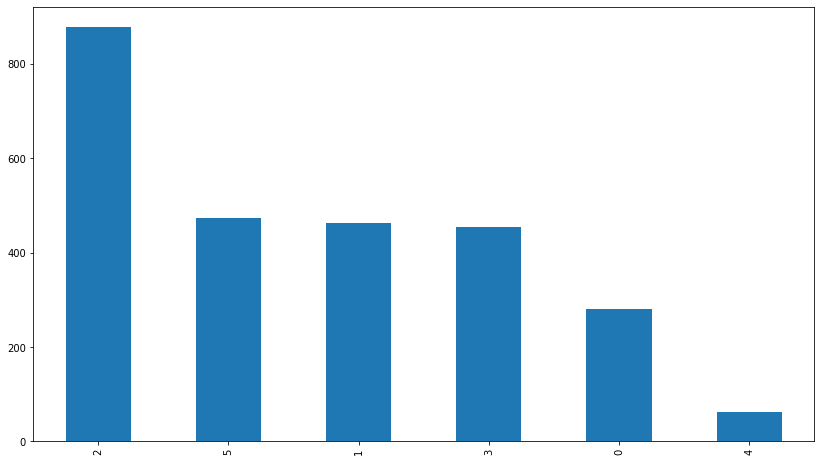

In [24]:
y_train.value_counts().plot(kind='bar', figsize=(14, 8)) # plotting the number of occurrences of each label

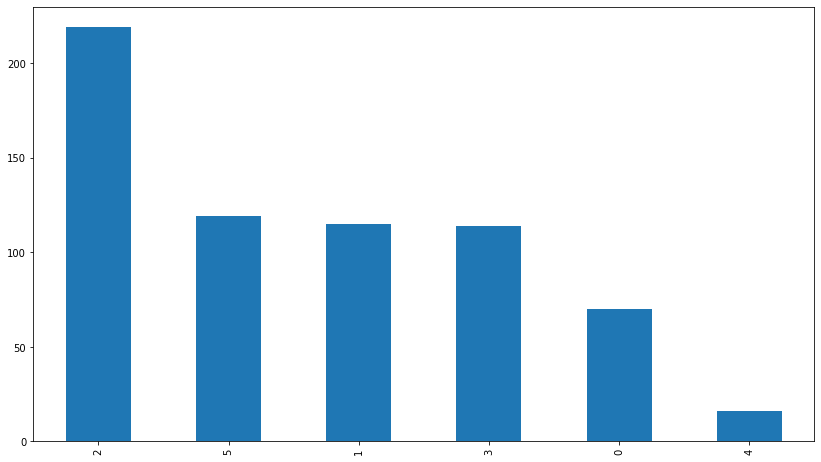

In [25]:
y_val.value_counts().plot(kind='bar', figsize=(14, 8)) # plotting the number of occurrences of each label

# Data Loaders

In [26]:
from torch.utils.data import Dataset, DataLoader
from PIL import Image

In [27]:
def load_image(infilename, infilegrayscale):
    """
    This function loads an image into memory when you give it the path of the image
    """
    if infilegrayscale:
      img = Image.open(infilename).convert('L')
    else:
      img = Image.open(infilename)
    #data = np.asarray(img)
    return img

In [28]:
class WaferDataset(Dataset):
    def __init__(self, path, labels, model=None):
        self.X = path
        self.y = labels
        self.model = model
        if self.model in ["BaseNet", "RegNet", "VicNet"]:
          self.infilegrayscale = True
        else:
          self.infilegrayscale = False

        # preprocessing
        if model in ["ResNet18", "VGG16"]: # validation
            self.preprocess = transforms.Compose([
              transforms.Resize(244),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              transforms.Lambda(lambda x: x.repeat(3, 1, 1)),  # duplicate channel as Resnet18 based on RGB
              transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
              # Data augmentation
              transforms.RandomHorizontalFlip(p=0.5),
              transforms.RandomRotation(30),
              transforms.RandomVerticalFlip(p=0.5)
            ])
        elif model in ["BaseNet", "RegNet", "VicNet", "MaxNet"]:
          self.preprocess = transforms.Compose([
              transforms.Resize(244),
              transforms.CenterCrop(224),
              transforms.ToTensor(),
              # Data augmentation
              transforms.RandomHorizontalFlip(p=0.5),
              transforms.RandomRotation(30),
              transforms.RandomVerticalFlip(p=0.5)
            ])
        
    def __len__(self):
        return (len(self.X))
    
    def __getitem__(self, i):
        image = load_image(self.X.iloc[i], self.infilegrayscale)
        label = self.y.iloc[i]
        if self.model is not None:
          image = self.preprocess(image)
        # print(image.shape)
        return torch.tensor(image, dtype=torch.float), torch.tensor(label, dtype=torch.long)

# Models

## Unregularized Model

In [29]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [30]:
from torchvision import models

In [31]:
class BaseNet(nn.Module):
  def __init__(self, input_shape=(1, 224, 224)):
    super().__init__()
    # Here, we define all the weights for the neural network, they are abstracted by layers. Internally however, they are represented by Pytorch tensors.
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=config.kernel_size)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=config.kernel_size)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=config.kernel_size)

    self.pool = nn.MaxPool2d(kernel_size=2)

    n_size = self._get_conv_output(input_shape)

    self.fc1 = nn.Linear(in_features=n_size, out_features=config.fc_layer_size)
    self.fc2 = nn.Linear(in_features=config.fc_layer_size, out_features=len(lb.classes_))

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size
  
  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x
  
  def forward(self, x):
      # Here, we define how an input x is translated into an output. In our linear example, this was simply (x^T * w), now it becomes more complex but
      # we don't have to care about that (gradients etc. are taken care of by Pytorch).
      x = self._forward_features(x)
      # You can always print shapes and tensors here. This is very very helpful to debug.
      # print("x.shape:", x.shape)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.fc2(x)
      return x

In [32]:
basenet = BaseNet()
basenet = basenet.to(runtime)

print(basenet)

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


BaseNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
)


## Regularized Model

In [33]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [34]:
class RegNet(nn.Module):
  def __init__(self, input_shape=(1, 224, 224)):
    super().__init__()
    # Here, we define all the weights for the neural network, they are abstracted by layers. Internally however, they are represented by Pytorch tensors.
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=config.kernel_size)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=config.kernel_size)
    self.batchnorm2 = nn.BatchNorm2d(64)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=config.kernel_size)
    self.batchnorm3 = nn.BatchNorm2d(128)

    self.pool = nn.MaxPool2d(kernel_size=2)

    n_size = self._get_conv_output(input_shape)

    self.fc1 = nn.Linear(in_features=n_size, out_features=config.fc_layer_size)
    self.fc2 = nn.Linear(in_features=config.fc_layer_size, out_features=len(lb.classes_))
    
    self.softmax = nn.LogSoftmax(dim=1)
    self.dropout = nn.Dropout2d(config.dropout)


  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size
  
  def _forward_features(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))
    return x
  
  def forward(self, x):
      # Here, we define how an input x is translated into an output. In our linear example, this was simply (x^T * w), now it becomes more complex but
      # we don't have to care about that (gradients etc. are taken care of by Pytorch).
      x = self._forward_features(x)
      # You can always print shapes and tensors here. This is very very helpful to debug.
      # print("x.shape:", x.shape)
      x = x.view(x.size(0), -1)
      x = F.relu(self.fc1(x))
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

In [35]:
regnet = RegNet()
regnet = regnet.to(runtime)

print(regnet)

RegNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (batchnorm3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=86528, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=6, bias=True)
  (softmax): LogSoftmax(dim=1)
  (dropout): Dropout2d(p=0.5, inplace=False)
)


## VicNet

In [36]:
class resBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size=3, stride=1):
      super().__init__()
      self.in_channels = in_channels
      self.out_channels = out_channels
      self.kernel_size = kernel_size
      self.stride = stride
      self.downsample = None

      if stride != 1 or in_channels != out_channels:
        self.downsample = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, 1, self.stride),
                                        nn.BatchNorm2d(self.out_channels))

      self.block = nn.Sequential(nn.Conv2d(self.in_channels, self.out_channels, self.kernel_size, self.stride, padding=1),
                                nn.BatchNorm2d(self.out_channels),
                                nn.ReLU(),
                                nn.Conv2d(self.out_channels, self.out_channels, self.kernel_size, 1, padding=1),
                                nn.BatchNorm2d(self.out_channels))
      self.relu = nn.ReLU()

                               
    def forward(self, x):
      skip = x
      x = self.block(x)
      if self.downsample is not None:
        skip = self.downsample(skip)
      x += skip
      x = self.relu(x)
      return x

In [37]:
class VicNet(nn.Module):
  def __init__(self, input_shape=(1, 224, 224)):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=config.kernel_size)
    self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=config.kernel_size)
    self.max_pool = nn.MaxPool2d(kernel_size=2)
    self.dropout = nn.Dropout2d(config.dropout)
    self.block1 = resBlock(in_channels=32, out_channels=32)
    self.block2 = resBlock(in_channels=32, out_channels=64, stride=2)
    self.block3 = resBlock(in_channels=64, out_channels=128, stride=2)
    self.block4 = resBlock(in_channels=128, out_channels=256)
    self.avg_pool = nn.AvgPool2d(kernel_size=2)

    n_size = self._get_conv_output(input_shape)

    self.fc1 = nn.Linear(in_features=n_size, out_features=config.fc_layer_size)
    self.fc2 = nn.Linear(in_features=config.fc_layer_size, out_features=len(lb.classes_))

  def _get_conv_output(self, shape):
    batch_size = 1
    input = torch.autograd.Variable(torch.rand(batch_size, *shape))
    output_feat = self._forward_features(input)
    n_size = output_feat.data.view(batch_size, -1).size(1)
    return n_size
  
  def _forward_features(self, x):
    x = self.max_pool(F.relu(self.conv1(x)))
    x = self.max_pool(F.relu(self.conv2(x)))
    x = self.block1(x)
    x = self.block2(x)
    x = self.block3(x)
    x = self.block4(x)
    x = self.avg_pool(x)
    return x

  def forward(self, x):
    x = self._forward_features(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [38]:
vicnet = VicNet()
vicnet = vicnet.to(runtime)

print(vicnet)

VicNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (max_pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout2d(p=0.5, inplace=False)
  (block1): resBlock(
    (block): Sequential(
      (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (relu): ReLU()
  )
  (block2): resBlock(
    (downsample): Sequential(
      (0): Conv2d(32, 64, kernel_size=(1, 1), stride=(2, 2))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (block): Sequential(
      (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1,

## MaxNet

In [39]:
class Flatten(nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)


class ConnectionBlock(nn.Module):
    def __init__(self, in_c, out_c, stride):
        super().__init__()

        self.pathA = nn.Sequential(
            nn.Conv2d(
                in_channels=in_c,
                out_channels=out_c,
                kernel_size=3,
                stride=stride,
                padding=1),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_c,
                out_channels=out_c,
                kernel_size=3,
                stride=1,
                padding=1),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU())

        self.pathB = nn.Sequential(
            nn.Conv2d(
                in_channels=in_c,
                out_channels=out_c,
                kernel_size=5,
                stride=stride,
                padding=2),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_c,
                out_channels=out_c,
                kernel_size=5,
                stride=1,
                padding=2),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU())

        self.pathC = nn.Sequential(
            nn.Conv2d(
                in_channels=in_c,
                out_channels=out_c,
                kernel_size=9,
                stride=stride,
                padding=4),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=out_c,
                out_channels=out_c,
                kernel_size=9,
                stride=1,
                padding=4),
            nn.BatchNorm2d(num_features=out_c),
            nn.ReLU())

        self.pathSkip = nn.Sequential(
            nn.Conv2d(
                in_channels=in_c,
                out_channels=out_c,
                kernel_size=1,
                stride=stride),
            nn.BatchNorm2d(num_features=out_c))

    def forward(self, x):
        return self.pathA(x) + self.pathB(x) + self.pathC(x) + self.pathSkip(x)


class MaxNet(nn.Module):
    def __init__(self, out_classes=len(lb.classes_), input_shape=(1, 224, 224)):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=7, stride=2),
            nn.BatchNorm2d(num_features=64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
            ConnectionBlock(in_c=64, out_c=64, stride=1),
            ConnectionBlock(in_c=64, out_c=128, stride=2),
            ConnectionBlock(in_c=128, out_c=256, stride=2),
            ConnectionBlock(in_c=256, out_c=256, stride=2),
            nn.AvgPool2d(kernel_size=(2, 2)),
            Flatten(),
            nn.Linear(in_features=512*16, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=256),
            nn.ReLU(),
            nn.Linear(in_features=256, out_features=out_classes),
            #nn.Sigmoid()
            )

    def forward(self, x):
        return self.net(x)

In [40]:
maxnet = MaxNet()
maxnet = maxnet.to(runtime)

print(maxnet)

MaxNet(
  (net): Sequential(
    (0): Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): ConnectionBlock(
      (pathA): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (5): ReLU()
      )
      (pathB): Sequential(
        (0): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
        (3): Conv2d(64, 64, kernel_size=(5, 5), stride=(1, 1

## ResNet

In [41]:
from torchvision import models

In [42]:
resnet18 = models.resnet18(pretrained=True)  
for param in resnet18.parameters():
  param.requires_grad=False # freezes the layers to only fine-tune the last one

print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## VGG

Also try VGG16 without batch norm

In [43]:
vgg16 = models.vgg16_bn(pretrained=True)
for param in vgg16.features.parameters():
  param.requires_grad=False # freezes the layers to only fine-tune the last one

print(vgg16)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

# Model Selection

In [44]:
list_transfer_model = ['ResNet18', 'VGG16']

w = widgets.Dropdown(options={'VicNet': vicnet,
                              'ResNet18': resnet18, 
                              'VGG16': vgg16, 
                              'RegNet': regnet, 
                              'BaseNet': basenet, 
                              'MaxNet': maxnet})
display(w)

Dropdown(options={'VicNet': VicNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Con…

In [45]:
print(f'Selected Net: {w.label}')
w.value

Selected Net: VGG16


VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [46]:
net = w.value

# Training

To measuse inference time: https://towardsdatascience.com/the-correct-way-to-measure-inference-time-of-deep-neural-networks-304a54e5187f

In [47]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
   if hasattr(layer, 'reset_parameters'):
    print(f'Reset trainable parameters of layer = {layer}')
    layer.reset_parameters()

In [48]:
def train(config=None):
  wandb.init(config=config_defaults)
  config = wandb.config

  early_stopping_counter = 0
  epochs = config.epochs
  if w.label in list_transfer_model:
    transferlearning = True
  else:
    transferlearning = False

  train_data = WaferDataset(X_train, y_train, model=w.label)
  val_data = WaferDataset(X_val, y_val, model=w.label)
    
  # dataloaders
  train_dataloader = DataLoader(train_data, batch_size=config.batch_size, shuffle=True)  # shuffle here instead of in model
  val_dataloader = DataLoader(val_data, batch_size=config.batch_size, shuffle=False)

  # Init the neural network
  if transferlearning:
    # Setup / deepcopy transfer learning model based on selected backbone transfer model 
    net = copy.deepcopy(w.value)
    # Add Classifier Layer to backbone transfer model
    net.fc = nn.Linear(config.fc_layer_size, len(lb.classes_))
    # Model to Cuda
    net = net.to(runtime)
  else:
    net = w.value
    net.apply(reset_weights)

  print('\n')

  # Define the optimizer
  if config.optimizer=='sgd':
    optimizer = torch.optim.SGD(net.parameters(), lr=config.learning_rate, momentum=0.9)
  elif config.optimizer=='adam':
    optimizer = torch.optim.Adam(net.parameters(), lr=config.learning_rate)
  elif config.optimizer=='adadelta':
    optimizer = torch.optim.Adadelta(net.parameters(), lr=config.learning_rate, rho=0.9, eps=1e-06, weight_decay=0)

  loss_fct = nn.CrossEntropyLoss()

  train_losses = []
  val_losses = []
  train_acc = []
  val_acc = []
  acc_val = 0
  acc_train = 0
  batch_ct = 0
  example_ct = 0


  starter, ender = torch.cuda.Event(enable_timing=True), torch.cuda.Event(enable_timing=True)
  timings=[]
  frames = []

  for epoch in range(epochs):
    # This command tells the neural network that it should be in training-mode now.
    # This call is important as some functions in neural networks (e.g., dropout) should 
    # only be applied when training
    net.train()

    total=0
    correct=0

    epoch_train_loss = 0.
    # Iterate over the dataset in chunks of size 32 (the batches)
    for i, data in enumerate(train_dataloader):
      X_batch, y_batch = data[0].to(runtime), data[1].to(runtime)

      y_pred = net(X_batch)
      loss = loss_fct(y_pred, y_batch)

      example_ct += len(data)

      epoch_train_loss += loss.item() * X_batch.size(0)

      _,pred = torch.max(y_pred, dim=1)

      #add the count of correct prediction of the batch to a correct prediction list
      correct += torch.sum(pred==y_batch).item()
      #add the count of all predictions of the batch to a total prediction list
      total += y_batch.size(0)
      #calculate accuracy of all predicted samples so far
      acc_train = 100 * correct/total

      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    epoch_train_loss = epoch_train_loss / len(train_dataloader.sampler)
    wandb.log({"epoch": epoch, "train_loss": epoch_train_loss, "train_accuracy": acc_train})
    print(f"Loss after " + str(example_ct).zfill(5) + f" examples: {epoch_train_loss:.3f}")
    train_losses.append(epoch_train_loss)
    train_acc.append(acc_train)


    net.eval()

    total_t=0
    correct_t=0

    # Init or reset the prediction and label lists(tensors) of a epoch
    predlist=torch.zeros(0,dtype=torch.long, device=runtime)
    lbllist=torch.zeros(0,dtype=torch.long, device=runtime)


    epoch_val_loss = 0. #reset epoch loss from validation

    # This command tells the neural network that it should be in evaluation mode now.
    # This call turns of special functions for training, such as dropout. 
    
    with torch.no_grad():
      for X_batch_val, y_batch_val in (val_dataloader):
        #load batch of validation data
        X_batch_val, y_batch_val = X_batch_val.to(runtime), y_batch_val.to(runtime)

        #predict batch
        starter.record()
        y_pred_val = net(X_batch_val)
        ender.record()

        if runtime == torch.device('cuda'):
            torch.cuda.synchronize() 

        laps_time = starter.elapsed_time(ender)
        
        timings.append(laps_time / X_batch_val.size(0))
        frames.append(X_batch_val.size(0) / laps_time)

        
        loss_val = loss_fct(y_pred_val.squeeze(), y_batch_val)
        # append loss of batch to epoch loss
        epoch_val_loss += loss_val.item() * X_batch_val.size(0)
                                              
        _,pred_t = torch.max(y_pred_val, dim=1)

        #add the count of correct prediction of the batch to a correct prediction list
        correct_t += torch.sum(pred_t==y_batch_val).item()
        #add the count of all predictions of the batch to a total prediction list
        total_t += y_batch_val.size(0)
        #calculate accuracy of all predicted samples so far
        acc_val = 100 * correct_t/total_t

        # Concatenate the prediction of a batch to list of all prediction of a epoch
        predlist=torch.cat([predlist,pred_t.view(-1).to(runtime)])
        lbllist=torch.cat([lbllist,y_batch_val.view(-1).to(runtime)])

      # log the test accuracy
      wandb.log({"val_loss": epoch_val_loss / len(val_dataloader.sampler), "val_accuracy": acc_val})


      epoch_val_loss = epoch_val_loss / len(val_dataloader.sampler)
      val_losses.append(epoch_val_loss)
      val_acc.append(acc_val)
      print('Avg execution time (ms): {:.3f}'.format(np.mean(timings)))
      print('Avg frames per seconds (fps): {:.3f}'.format(np.mean(frames)))
      print('Epoch: {} ->  Train loss: {} Val loss: {} Train Accuracy: {} Val Accuracy: {}'.format(epoch, epoch_train_loss, epoch_val_loss, acc_train, acc_val))


  y_true = lbllist.cpu().numpy()
  y_pred = predlist.cpu().numpy()

  # Confusion matrix
  conf_mat=confusion_matrix(y_true, y_pred)
  print('\n')
  print(f'Total Prediction: {len(predlist)}')
  print(f'Correct Prediction: {sum(conf_mat.diagonal())}')
  print('Confusion matrix')
  print(conf_mat)
  print('\n')

  # Precision, Recall, F1-score
  class_report_print = classification_report(y_true, y_pred)
  print(class_report_print)

  # Per-class accuracy
  class_accuracy=100*conf_mat.diagonal()/conf_mat.sum(1)
  overall_accuracy = 100 * sum(conf_mat.diagonal()) / len(predlist)
  print(f'Per-class accuracy: {class_accuracy}')
  print(f'Overall accuracy: {overall_accuracy}')
  print('\n')

## Run the sweep agent

In [ ]:
wandb.agent(sweep_id, train)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.
wandb: Agent Starting Run: bw7dplm2 with config:
wandb: 	batch_size: 64
wandb: 	dropout: 0.7
wandb: 	epochs: 100
wandb: 	fc_layer_size: 512
wandb: 	kernel_size: 5
wandb: 	learning_rate: 3e-05
wandb: 	optimizer: adam


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:44: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Loss after 00082 examples: 2.730
Avg execution time (ms): 5.486
Avg frames per seconds (fps): 0.182
Epoch: 0 ->  Train loss: 2.730066133065956 Val loss: 1.3494476992722493 Train Accuracy: 30.86939869781693 Val Accuracy: 50.995405819295556
Loss after 00164 examples: 1.375
Avg execution time (ms): 5.145
Avg frames per seconds (fps): 0.195
Epoch: 1 ->  Train loss: 1.3749519397544934 Val loss: 1.0591117792618767 Train Accuracy: 50.248946763692075 Val Accuracy: 65.08422664624808
Loss after 00246 examples: 1.127
Avg execution time (ms): 5.036
Avg frames per seconds (fps): 0.199
Epoch: 2 ->  Train loss: 1.1273092546028363 Val loss: 0.9361989329273814 Train Accuracy: 59.51742627345845 Val Accuracy: 69.52526799387442
Loss after 00328 examples: 0.977
Avg execution time (ms): 4.979
Avg frames per seconds (fps): 0.202
Epoch: 3 ->  Train loss: 0.9766462959352009 Val loss: 0.8412831378202161 Train Accuracy: 64.87935656836461 Val Accuracy: 71.36294027565084
Loss after 00410 examples: 0.908
Avg execut

# Save Model

In [ ]:
SAVE_MODEL_PATH = "/content/drive/MyDrive/DEEPVIS/models"
#torch.save(net.state_dict(), SAVE_MODEL_PATH)
torch.save(net.state_dict(), os.path.join(SAVE_MODEL_PATH, w.label+'.pth'))

FileNotFoundError: ignored

In [ ]:
from pathlib import Path
my_path= '/content/drive/MyDrive/DEEPVIS/'

model = RegNet()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(copy.deepcopy(torch.load(Path(my_path + 'models/RegNet.pth'),device)))